# NEST 2.0 Clinical Trial - Complete Advanced Analytics Pipeline
## Comprehensive Analysis in One Notebook

This notebook performs the complete Advanced Analytics pipeline:
1. Data Ingestion & Harmonization
2. Data Quality Assessment
3. Exploratory Data Analysis
4. Feature Engineering
5. Labeling & Target Definition
6. Anomaly Detection
7. Predictive Modeling
8. Time Series Forecasting
9. Explainability
10. Monitoring & Drift Detection
11. Comprehensive Report

---

# PART 1: SETUP & DATA INGESTION

In [1]:
# ============================================================================
# IMPORTS & CONFIGURATION
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import json
import warnings
import os

# ML imports
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve, average_precision_score,
                             mean_absolute_error, mean_squared_error)
from scipy import stats

# Optional imports
try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except: HAS_LGBM = False

try:
    import shap
    HAS_SHAP = True
except: HAS_SHAP = False

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.arima.model import ARIMA
    HAS_STATSMODELS = True
except: HAS_STATSMODELS = False

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    HAS_PLOTLY = True
except: HAS_PLOTLY = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Paths
BASE_DIR = Path(os.getcwd())
if BASE_DIR.name == 'notebooks':
    BASE_DIR = BASE_DIR.parent

RAW_DATA_PATH = BASE_DIR / 'Data' / 'NEST 2.0 data' / 'QC Anonymized Study Files'
OLD_PROCESSED_PATH = BASE_DIR / 'processed_data'
OUTPUT_PATH = BASE_DIR / 'analytics_output'
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

INGESTION_TIME = datetime.utcnow().isoformat() + 'Z'

print(f"Base Directory: {BASE_DIR}")
print(f"Output Path: {OUTPUT_PATH}")
print(f"Libraries: LightGBM={HAS_LGBM}, SHAP={HAS_SHAP}, Statsmodels={HAS_STATSMODELS}, Plotly={HAS_PLOTLY}")

Base Directory: c:\Users\mrinm\OneDrive\Documents\novartis\Novartis
Output Path: c:\Users\mrinm\OneDrive\Documents\novartis\Novartis\analytics_output
Libraries: LightGBM=False, SHAP=True, Statsmodels=True, Plotly=True


In [2]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================
FILE_TYPE_PATTERNS = {
    'edrr': ['EDRR', 'Compiled_EDRR'],
    'meddra': ['MedDRA', 'GlobalCodingReport_MedDRA'],
    'whodd': ['WHODD', 'WHODrug', 'GlobalCodingReport_WHODD'],
    'esae': ['eSAE', 'SAE Dashboard', 'SAE_Dashboard'],
    'missing_pages': ['Missing_Page', 'Missing Page'],
    'visit_projection': ['Visit Projection', 'Visit_Projection']
}

def load_processed_data(name):
    """Load data from processed folder."""
    for path in [OUTPUT_PATH, OLD_PROCESSED_PATH]:
        for suffix in ['_processed.csv', '.csv', '_processed.parquet']:
            filepath = path / f"{name}{suffix}"
            if filepath.exists():
                if suffix.endswith('.parquet'):
                    return pd.read_parquet(filepath)
                return pd.read_csv(filepath)
    return pd.DataFrame()

def standardize_columns(df):
    """Standardize column names to snake_case."""
    df.columns = (df.columns.str.strip().str.lower()
                  .str.replace(r'[^a-z0-9]+', '_', regex=True).str.strip('_'))
    return df

def get_study_col(df):
    cols = [c for c in df.columns if 'study' in c.lower() and 'source' not in c.lower()]
    return cols[0] if cols else '_source_study' if '_source_study' in df.columns else None

print("Data loading functions defined.")

Data loading functions defined.


In [3]:
# ============================================================================
# LOAD ALL DATASETS
# ============================================================================
print("Loading datasets...")

datasets = {}
for name in ['edrr', 'meddra', 'whodd', 'esae_dashboard', 'missing_pages', 'visit_projection']:
    df = load_processed_data(name)
    if df.empty and name == 'esae_dashboard':
        df = load_processed_data('esae')
    if not df.empty:
        df = standardize_columns(df)
    key = 'esae' if 'esae' in name else name
    datasets[key] = df
    print(f"  {key}: {df.shape if not df.empty else 'Empty'}")

# Quick access
df_edrr = datasets.get('edrr', pd.DataFrame())
df_meddra = datasets.get('meddra', pd.DataFrame())
df_whodd = datasets.get('whodd', pd.DataFrame())
df_esae = datasets.get('esae', pd.DataFrame())
df_missing_pages = datasets.get('missing_pages', pd.DataFrame())
df_visit = datasets.get('visit_projection', pd.DataFrame())

Loading datasets...
  edrr: (893, 4)


  meddra: (66858, 11)


  whodd: (306702, 11)
  esae: (17098, 11)
  missing_pages: (5524, 13)
  visit_projection: (871, 9)


# PART 2: DATA QUALITY ASSESSMENT

In [4]:
# ============================================================================
# DATA QUALITY CHECKER
# ============================================================================
class DataQualityChecker:
    def __init__(self, df, name):
        self.df = df
        self.name = name
        self.results = {'dataset': name, 'total_rows': len(df), 'checks': []}
    
    def check_completeness(self):
        for col in self.df.columns:
            pct = self.df[col].isnull().mean()
            if pct > 0:
                sev = 'ERROR' if pct > 0.2 else 'WARN' if pct > 0.05 else 'INFO'
                self.results['checks'].append({
                    'type': 'completeness', 'column': col, 'value': round(pct*100, 2), 'severity': sev
                })
        return self
    
    def get_summary(self):
        checks = self.results['checks']
        self.results['summary'] = {
            'errors': len([c for c in checks if c['severity'] == 'ERROR']),
            'warnings': len([c for c in checks if c['severity'] == 'WARN'])
        }
        return self.results

# Run DQ checks
print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

dq_results = {}
dq_scores = {}

for name, df in datasets.items():
    if df.empty:
        continue
    checker = DataQualityChecker(df, name).check_completeness()
    results = checker.get_summary()
    dq_results[name] = results
    
    # Simple DQ score
    penalty = results['summary']['errors'] * 10 + results['summary']['warnings'] * 3
    score = max(0, 100 - penalty)
    dq_scores[name] = score
    
    status = "✅" if score >= 80 else "⚠️" if score >= 60 else "🔴"
    print(f"  {status} {name}: DQ Score = {score}/100 (Errors: {results['summary']['errors']}, Warnings: {results['summary']['warnings']})")

overall_dq = np.mean(list(dq_scores.values())) if dq_scores else 0
print(f"\n  Overall DQ Score: {overall_dq:.1f}/100")


DATA QUALITY ASSESSMENT
  ✅ edrr: DQ Score = 100/100 (Errors: 0, Warnings: 0)
  ✅ meddra: DQ Score = 100/100 (Errors: 0, Warnings: 0)
  ✅ whodd: DQ Score = 100/100 (Errors: 0, Warnings: 0)
  ⚠️ esae: DQ Score = 60/100 (Errors: 4, Warnings: 0)
  🔴 missing_pages: DQ Score = 54/100 (Errors: 4, Warnings: 2)
  ⚠️ visit_projection: DQ Score = 60/100 (Errors: 4, Warnings: 0)

  Overall DQ Score: 79.0/100


# PART 3: EXPLORATORY DATA ANALYSIS

In [5]:
# ============================================================================
# EDA - KEY METRICS SUMMARY
# ============================================================================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# EDRR Analysis
if not df_edrr.empty:
    issue_col = [c for c in df_edrr.columns if 'issue' in c.lower() and 'count' in c.lower()]
    if issue_col:
        total_issues = df_edrr[issue_col[0]].sum()
        print(f"\n📊 OPEN ISSUES:")
        print(f"   Total Open Issues: {total_issues:,.0f}")
        print(f"   Subjects Affected: {len(df_edrr):,}")

# Coding Analysis
if not df_meddra.empty:
    coding_col = [c for c in df_meddra.columns if 'coding' in c.lower() and 'status' in c.lower()]
    if coding_col:
        coded = df_meddra[coding_col[0]].str.lower().str.contains('coded term', na=False)
        uncoded = df_meddra[coding_col[0]].str.lower().str.contains('uncoded', na=False)
        coded_pct = (coded & ~uncoded).mean() * 100
        print(f"\n💊 MEDDRA CODING:")
        print(f"   Total AE Records: {len(df_meddra):,}")
        print(f"   Coding Rate: {coded_pct:.1f}%")

if not df_whodd.empty:
    coding_col = [c for c in df_whodd.columns if 'coding' in c.lower() and 'status' in c.lower()]
    if coding_col:
        coded = df_whodd[coding_col[0]].str.lower().str.contains('coded term', na=False)
        uncoded = df_whodd[coding_col[0]].str.lower().str.contains('uncoded', na=False)
        coded_pct = (coded & ~uncoded).mean() * 100
        print(f"\n💉 WHODD CODING:")
        print(f"   Total Drug Records: {len(df_whodd):,}")
        print(f"   Coding Rate: {coded_pct:.1f}%")

# Safety Events
if not df_esae.empty:
    print(f"\n⚠️ SAFETY EVENTS:")
    print(f"   Total Records: {len(df_esae):,}")


EXPLORATORY DATA ANALYSIS

📊 OPEN ISSUES:
   Total Open Issues: 2,164
   Subjects Affected: 893



💊 MEDDRA CODING:
   Total AE Records: 66,858
   Coding Rate: 99.4%



💉 WHODD CODING:
   Total Drug Records: 306,702
   Coding Rate: 99.7%

⚠️ SAFETY EVENTS:
   Total Records: 17,098


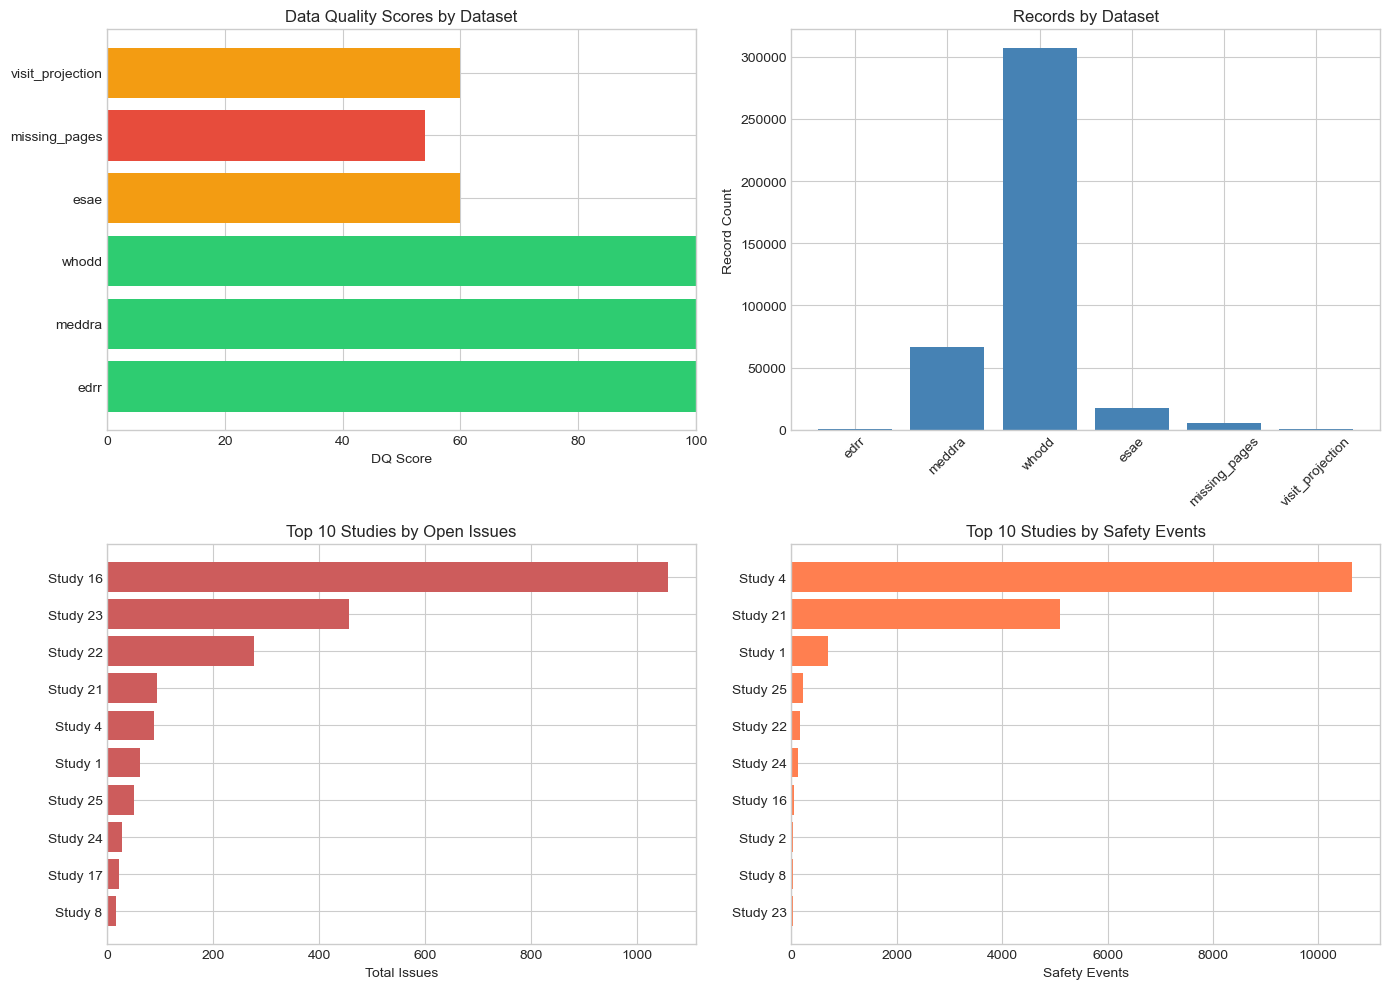


Saved: c:\Users\mrinm\OneDrive\Documents\novartis\Novartis\analytics_output\eda_overview.png


In [6]:
# ============================================================================
# EDA VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. DQ Scores
ax1 = axes[0, 0]
if dq_scores:
    colors = ['#2ecc71' if s >= 80 else '#f39c12' if s >= 60 else '#e74c3c' for s in dq_scores.values()]
    ax1.barh(list(dq_scores.keys()), list(dq_scores.values()), color=colors)
    ax1.set_xlabel('DQ Score')
    ax1.set_title('Data Quality Scores by Dataset')
    ax1.set_xlim(0, 100)

# 2. Record counts
ax2 = axes[0, 1]
record_counts = {k: len(v) for k, v in datasets.items() if not v.empty}
if record_counts:
    ax2.bar(record_counts.keys(), record_counts.values(), color='steelblue')
    ax2.set_ylabel('Record Count')
    ax2.set_title('Records by Dataset')
    ax2.tick_params(axis='x', rotation=45)

# 3. Issues by study (if available)
ax3 = axes[1, 0]
if not df_edrr.empty:
    study_col = get_study_col(df_edrr)
    issue_col = [c for c in df_edrr.columns if 'issue' in c.lower() and 'count' in c.lower()]
    if study_col and issue_col:
        study_issues = df_edrr.groupby(study_col)[issue_col[0]].sum().sort_values(ascending=False).head(10)
        ax3.barh(study_issues.index, study_issues.values, color='indianred')
        ax3.set_xlabel('Total Issues')
        ax3.set_title('Top 10 Studies by Open Issues')
        ax3.invert_yaxis()

# 4. Safety events by study
ax4 = axes[1, 1]
if not df_esae.empty:
    study_col = get_study_col(df_esae)
    if study_col:
        study_safety = df_esae.groupby(study_col).size().sort_values(ascending=False).head(10)
        ax4.barh(study_safety.index, study_safety.values, color='coral')
        ax4.set_xlabel('Safety Events')
        ax4.set_title('Top 10 Studies by Safety Events')
        ax4.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSaved: {OUTPUT_PATH / 'eda_overview.png'}")

# PART 4: FEATURE ENGINEERING

In [7]:
# ============================================================================
# BUILD STUDY-LEVEL FEATURES
# ============================================================================
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Get all studies
all_studies = set()
for df in datasets.values():
    if not df.empty:
        col = get_study_col(df)
        if col:
            all_studies.update(df[col].dropna().unique())

print(f"Found {len(all_studies)} unique studies")

# Build features
study_features = []

for study in all_studies:
    feat = {'study': study}
    
    # EDRR features
    if not df_edrr.empty:
        col = get_study_col(df_edrr)
        issue_col = [c for c in df_edrr.columns if 'issue' in c.lower() and 'count' in c.lower()]
        if col and issue_col:
            study_data = df_edrr[df_edrr[col] == study]
            feat['total_open_issues'] = study_data[issue_col[0]].sum() if len(study_data) > 0 else 0
            feat['subjects_with_issues'] = len(study_data)
    
    # MedDRA features
    if not df_meddra.empty:
        col = get_study_col(df_meddra)
        if col:
            study_data = df_meddra[df_meddra[col] == study]
            feat['total_ae_records'] = len(study_data)
            coding_col = [c for c in df_meddra.columns if 'coding' in c.lower() and 'status' in c.lower()]
            if coding_col and len(study_data) > 0:
                coded = (study_data[coding_col[0]].str.lower().str.contains('coded term', na=False) & 
                        ~study_data[coding_col[0]].str.lower().str.contains('uncoded', na=False)).sum()
                feat['ae_coding_rate'] = coded / len(study_data) if len(study_data) > 0 else 1
    
    # WHODD features
    if not df_whodd.empty:
        col = get_study_col(df_whodd)
        if col:
            study_data = df_whodd[df_whodd[col] == study]
            feat['total_drug_records'] = len(study_data)
    
    # Safety features
    if not df_esae.empty:
        col = get_study_col(df_esae)
        if col:
            study_data = df_esae[df_esae[col] == study]
            feat['total_safety_events'] = len(study_data)
    
    # Missing pages
    if not df_missing_pages.empty:
        col = get_study_col(df_missing_pages)
        if col:
            study_data = df_missing_pages[df_missing_pages[col] == study]
            feat['missing_pages_count'] = len(study_data)
    
    study_features.append(feat)

df_features = pd.DataFrame(study_features).fillna(0)
print(f"\nFeature matrix shape: {df_features.shape}")
print(f"Features: {df_features.columns.tolist()}")
df_features.head()


FEATURE ENGINEERING
Found 23 unique studies



Feature matrix shape: (23, 8)
Features: ['study', 'total_open_issues', 'subjects_with_issues', 'total_ae_records', 'ae_coding_rate', 'total_drug_records', 'total_safety_events', 'missing_pages_count']


,study,total_open_issues,subjects_with_issues,total_ae_records,ae_coding_rate,total_drug_records,total_safety_events,missing_pages_count
0,Study 16,1059,208,3771,0.997879,5305,44,136
1,Study 23,457,135,6362,0.999843,4206,21,18
2,Study 8,16,14,7403,0.997974,5042,21,39
3,Study 11,1,1,0,0.000000,4,14,25
4,Study 25,51,38,8681,1.000000,14693,217,0


# PART 5: LABELING & TARGET DEFINITION

In [8]:
# ============================================================================
# CREATE LABELS
# ============================================================================
print("\n" + "="*60)
print("LABELING & TARGET DEFINITION")
print("="*60)

df_labeled = df_features.copy()

# High risk study label
conditions = []
if 'total_open_issues' in df_labeled.columns:
    conditions.append(df_labeled['total_open_issues'] >= 50)
if 'total_safety_events' in df_labeled.columns:
    conditions.append(df_labeled['total_safety_events'] >= 100)
if 'missing_pages_count' in df_labeled.columns:
    conditions.append(df_labeled['missing_pages_count'] >= 100)

if conditions:
    df_labeled['label_high_risk'] = np.where(np.any(conditions, axis=0), 1, 0)
else:
    df_labeled['label_high_risk'] = 0

# Coding incomplete label
if 'ae_coding_rate' in df_labeled.columns:
    df_labeled['label_coding_incomplete'] = (df_labeled['ae_coding_rate'] < 0.98).astype(int)
else:
    df_labeled['label_coding_incomplete'] = 0

print(f"\nLabels created:")
print(f"  label_high_risk: {df_labeled['label_high_risk'].sum()} positive ({df_labeled['label_high_risk'].mean()*100:.1f}%)")
print(f"  label_coding_incomplete: {df_labeled['label_coding_incomplete'].sum()} positive ({df_labeled['label_coding_incomplete'].mean()*100:.1f}%)")


LABELING & TARGET DEFINITION

Labels created:
  label_high_risk: 12 positive (52.2%)
  label_coding_incomplete: 11 positive (47.8%)


# PART 6: ANOMALY DETECTION

In [9]:
# ============================================================================
# ANOMALY DETECTION
# ============================================================================
print("\n" + "="*60)
print("ANOMALY DETECTION")
print("="*60)

# Prepare numeric features
feature_cols = [c for c in df_labeled.columns if c not in ['study', 'label_high_risk', 'label_coding_incomplete']
                and df_labeled[c].dtype in ['int64', 'float64']]

if len(feature_cols) > 0 and len(df_labeled) > 5:
    X = df_labeled[feature_cols].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Z-Score
    z_scores = np.abs(stats.zscore(X, nan_policy='omit'))
    z_outliers = (z_scores > 3).any(axis=1)
    df_labeled['anomaly_zscore'] = z_outliers.astype(int)
    
    # Isolation Forest
    iso = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    iso_pred = iso.fit_predict(X_scaled)
    df_labeled['anomaly_iforest'] = (iso_pred == -1).astype(int)
    
    # LOF
    n_neighbors = min(20, max(5, len(df_labeled) // 3))
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
    lof_pred = lof.fit_predict(X_scaled)
    df_labeled['anomaly_lof'] = (lof_pred == -1).astype(int)
    
    # Ensemble
    anomaly_cols = ['anomaly_zscore', 'anomaly_iforest', 'anomaly_lof']
    df_labeled['anomaly_count'] = df_labeled[anomaly_cols].sum(axis=1)
    df_labeled['anomaly_ensemble'] = (df_labeled['anomaly_count'] >= 2).astype(int)
    
    print(f"\n🔍 Anomalies Detected:")
    print(f"   Z-Score: {df_labeled['anomaly_zscore'].sum()}")
    print(f"   Isolation Forest: {df_labeled['anomaly_iforest'].sum()}")
    print(f"   LOF: {df_labeled['anomaly_lof'].sum()}")
    print(f"   Ensemble (>=2 methods): {df_labeled['anomaly_ensemble'].sum()}")
    
    # Top anomalies
    if df_labeled['anomaly_ensemble'].sum() > 0:
        print(f"\n⚠️ Anomalous Studies:")
        for _, row in df_labeled[df_labeled['anomaly_ensemble'] == 1].head(5).iterrows():
            print(f"   🔴 {row['study']}: detected by {row['anomaly_count']} methods")
else:
    print("Insufficient data for anomaly detection.")


ANOMALY DETECTION



🔍 Anomalies Detected:
   Z-Score: 4
   Isolation Forest: 3
   LOF: 3
   Ensemble (>=2 methods): 4

⚠️ Anomalous Studies:
   🔴 Study 16: detected by 2 methods
   🔴 Study 22: detected by 2 methods
   🔴 Study 4: detected by 3 methods
   🔴 Study 21: detected by 3 methods


# PART 7: PREDICTIVE MODELING

In [10]:
# ============================================================================
# PREDICTIVE MODELING
# ============================================================================
print("\n" + "="*60)
print("PREDICTIVE MODELING")
print("="*60)

# Prepare features and target
exclude_cols = ['study', 'label_high_risk', 'label_coding_incomplete', 'anomaly_zscore', 
                'anomaly_iforest', 'anomaly_lof', 'anomaly_count', 'anomaly_ensemble']
feature_cols = [c for c in df_labeled.columns if c not in exclude_cols 
                and df_labeled[c].dtype in ['int64', 'float64']]

TARGET = 'label_high_risk'
model_results = []

if TARGET in df_labeled.columns and len(feature_cols) > 0 and len(df_labeled) > 10:
    X = df_labeled[feature_cols].fillna(0)
    y = df_labeled[TARGET]
    
    # Scale
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)
    
    # Split
    try:
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)
    except:
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
    
    print(f"\nTraining: {len(X_train)} samples, Test: {len(X_test)} samples")
    print(f"Target: {TARGET}")
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
    }
    if HAS_LGBM:
        models['LightGBM'] = LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced', verbose=-1)
    
    # Train and evaluate
    trained_models = {}
    print(f"\n📊 Model Performance:")
    
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            trained_models[name] = model
            
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
            
            auc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else 0.5
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            model_results.append({'Model': name, 'AUC-ROC': auc, 'F1': f1})
            print(f"   {name}: AUC={auc:.3f}, F1={f1:.3f}")
        except Exception as e:
            print(f"   {name}: Error - {str(e)[:30]}")
    
    # Best model
    if model_results:
        best = max(model_results, key=lambda x: x['AUC-ROC'])
        print(f"\n🏆 Best Model: {best['Model']} (AUC={best['AUC-ROC']:.3f})")
        
        # Add predictions to dataframe
        best_model = trained_models[best['Model']]
        df_labeled['prediction'] = best_model.predict(X_scaled)
        if hasattr(best_model, 'predict_proba'):
            df_labeled['probability'] = best_model.predict_proba(X_scaled)[:, 1]
else:
    print("Insufficient data for predictive modeling.")


PREDICTIVE MODELING

Training: 17 samples, Test: 6 samples
Target: label_high_risk

📊 Model Performance:
   Logistic Regression: AUC=1.000, F1=0.800


   Random Forest: AUC=1.000, F1=0.800
   Gradient Boosting: AUC=1.000, F1=1.000

🏆 Best Model: Logistic Regression (AUC=1.000)


# PART 8: TIME SERIES FORECASTING


TIME SERIES FORECASTING

Time series: 90 days
Train: 72, Test: 18



📈 Forecast Evaluation:
   Naive: MAE = 7.38
   Mean: MAE = 3.27
   Linear: MAE = 3.31
   ARIMA: MAE = 3.00


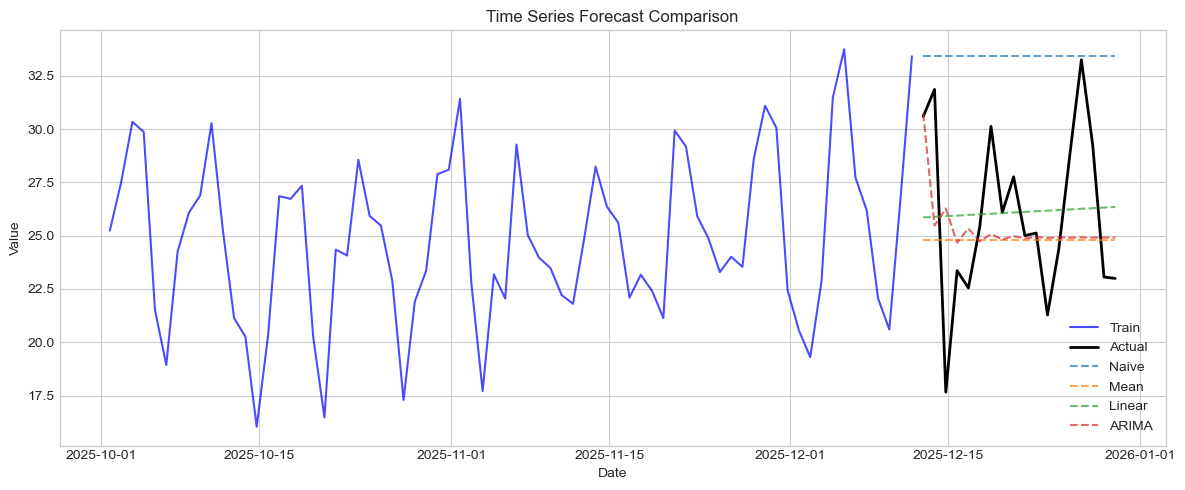

In [11]:
# ============================================================================
# TIME SERIES FORECASTING (Synthetic Demo)
# ============================================================================
print("\n" + "="*60)
print("TIME SERIES FORECASTING")
print("="*60)

# Create synthetic time series
np.random.seed(42)
n_days = 90
dates = pd.date_range(end=datetime.now(), periods=n_days, freq='D')

base_value = df_labeled['total_open_issues'].sum() / n_days if 'total_open_issues' in df_labeled.columns else 10
trend = np.linspace(0, 0.1 * base_value, n_days)
seasonality = 0.2 * base_value * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = 0.1 * base_value * np.random.randn(n_days)
ts_data = np.maximum(base_value + trend + seasonality + noise, 0)

df_ts = pd.DataFrame({'date': dates, 'value': ts_data}).set_index('date')

# Split
train_size = int(len(df_ts) * 0.8)
train_ts = df_ts.iloc[:train_size]
test_ts = df_ts.iloc[train_size:]

print(f"\nTime series: {len(df_ts)} days")
print(f"Train: {len(train_ts)}, Test: {len(test_ts)}")

# Simple forecasts
forecasts = {}
forecasts['Naive'] = np.full(len(test_ts), train_ts['value'].iloc[-1])
forecasts['Mean'] = np.full(len(test_ts), train_ts['value'].mean())

# Linear trend
X_tr = np.arange(len(train_ts)).reshape(-1, 1)
lr = LinearRegression().fit(X_tr, train_ts['value'])
X_te = np.arange(len(train_ts), len(train_ts) + len(test_ts)).reshape(-1, 1)
forecasts['Linear'] = lr.predict(X_te)

# ARIMA if available
if HAS_STATSMODELS:
    try:
        arima = ARIMA(train_ts['value'], order=(2, 1, 2)).fit()
        forecasts['ARIMA'] = arima.forecast(len(test_ts)).values
    except:
        pass

# Evaluate
print(f"\n📈 Forecast Evaluation:")
for name, pred in forecasts.items():
    mae = mean_absolute_error(test_ts['value'], pred)
    print(f"   {name}: MAE = {mae:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train_ts.index, train_ts['value'], 'b-', label='Train', alpha=0.7)
plt.plot(test_ts.index, test_ts['value'], 'k-', label='Actual', linewidth=2)
for name, pred in forecasts.items():
    plt.plot(test_ts.index, pred, '--', label=name, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Forecast Comparison')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'forecast.png', dpi=150, bbox_inches='tight')
plt.show()

# PART 9: EXPLAINABILITY


MODEL EXPLAINABILITY

🔍 Top 10 Features (Random Forest):
   - total_open_issues: 0.2720
   - subjects_with_issues: 0.2184
   - total_drug_records: 0.1934
   - missing_pages_count: 0.1358
   - total_ae_records: 0.0756
   - total_safety_events: 0.0599
   - ae_coding_rate: 0.0449


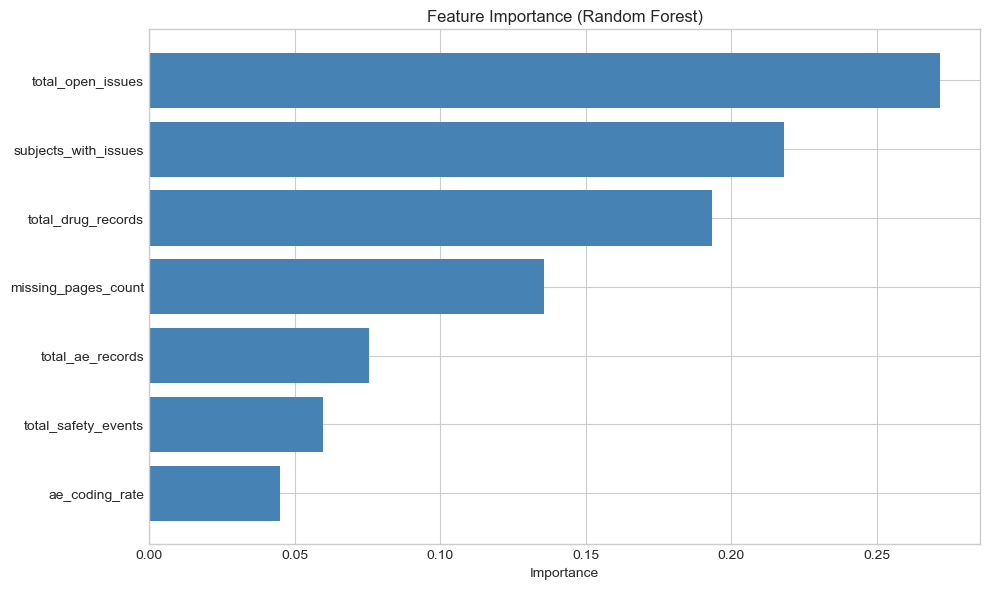


⚠️ Top 5 High-Risk Studies:
   🔴 Study 22: 99.4% risk
   🔴 Study 16: 98.6% risk
   🔴 Study 4: 97.7% risk
   🔴 Study 21: 93.3% risk
   🔴 Study 23: 88.9% risk


In [12]:
# ============================================================================
# MODEL EXPLAINABILITY
# ============================================================================
print("\n" + "="*60)
print("MODEL EXPLAINABILITY")
print("="*60)

if 'trained_models' in dir() and trained_models:
    # Get best tree-based model for feature importance
    best_tree = None
    for name in ['LightGBM', 'Random Forest', 'Gradient Boosting']:
        if name in trained_models:
            best_tree = trained_models[name]
            best_name = name
            break
    
    if best_tree and hasattr(best_tree, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_tree.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\n🔍 Top 10 Features ({best_name}):")
        for _, row in importance.head(10).iterrows():
            print(f"   - {row['feature']}: {row['importance']:.4f}")
        
        # Plot
        plt.figure(figsize=(10, 6))
        top_15 = importance.head(15)
        plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
        plt.yticks(range(len(top_15)), top_15['feature'])
        plt.xlabel('Importance')
        plt.title(f'Feature Importance ({best_name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH / 'feature_importance.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # High-risk explanations
    if 'probability' in df_labeled.columns:
        print(f"\n⚠️ Top 5 High-Risk Studies:")
        for _, row in df_labeled.nlargest(5, 'probability').iterrows():
            prob = row['probability'] * 100
            print(f"   🔴 {row['study']}: {prob:.1f}% risk")
else:
    print("No trained models available for explainability.")

# PART 10: MONITORING & DRIFT DETECTION

In [13]:
# ============================================================================
# MONITORING & DRIFT DETECTION
# ============================================================================
print("\n" + "="*60)
print("MONITORING & DRIFT DETECTION")
print("="*60)

def calculate_psi(ref, prod, n_bins=10):
    """Calculate Population Stability Index."""
    ref, prod = ref.dropna(), prod.dropna()
    if len(ref) == 0 or len(prod) == 0:
        return 0.0
    bins = np.linspace(min(ref.min(), prod.min()), max(ref.max(), prod.max()), n_bins + 1)
    ref_pct = (np.histogram(ref, bins)[0] + 0.001) / (len(ref) + 0.001 * n_bins)
    prod_pct = (np.histogram(prod, bins)[0] + 0.001) / (len(prod) + 0.001 * n_bins)
    return np.sum((prod_pct - ref_pct) * np.log(prod_pct / ref_pct))

# Simulate reference vs production split
if len(df_labeled) > 10:
    split = int(len(df_labeled) * 0.7)
    ref_df = df_labeled.iloc[:split]
    prod_df = df_labeled.iloc[split:]
    
    drift_cols = [c for c in feature_cols if c in df_labeled.columns][:10]
    drift_results = []
    
    for col in drift_cols:
        psi = calculate_psi(ref_df[col], prod_df[col])
        status = 'HIGH DRIFT' if psi > 0.2 else 'MODERATE' if psi > 0.1 else 'OK'
        drift_results.append({'feature': col, 'psi': psi, 'status': status})
    
    drift_df = pd.DataFrame(drift_results).sort_values('psi', ascending=False)
    
    print(f"\n📊 Drift Analysis (Reference: {len(ref_df)}, Production: {len(prod_df)}):")
    high_drift = (drift_df['status'] == 'HIGH DRIFT').sum()
    moderate_drift = (drift_df['status'] == 'MODERATE').sum()
    print(f"   High Drift: {high_drift} features")
    print(f"   Moderate Drift: {moderate_drift} features")
    print(f"   OK: {(drift_df['status'] == 'OK').sum()} features")
    
    # Retrain decision
    max_psi = drift_df['psi'].max()
    if max_psi > 0.2 or high_drift > 2:
        print(f"\n⚠️ RETRAIN RECOMMENDED (Max PSI: {max_psi:.3f})")
    else:
        print(f"\n✅ No retrain needed (Max PSI: {max_psi:.3f})")
else:
    print("Insufficient data for drift detection.")


MONITORING & DRIFT DETECTION

📊 Drift Analysis (Reference: 16, Production: 7):
   High Drift: 7 features
   Moderate Drift: 0 features
   OK: 0 features

⚠️ RETRAIN RECOMMENDED (Max PSI: 3.588)


# PART 11: COMPREHENSIVE REPORT

In [14]:
# ============================================================================
# COMPREHENSIVE ANALYTICS REPORT
# ============================================================================
print("\n" + "="*70)
print("COMPREHENSIVE ANALYTICS REPORT")
print("="*70)

report = {
    'generated_at': datetime.utcnow().isoformat() + 'Z',
    'summary': {
        'total_studies': len(all_studies),
        'overall_dq_score': round(overall_dq, 1),
        'anomalies_detected': int(df_labeled['anomaly_ensemble'].sum()) if 'anomaly_ensemble' in df_labeled.columns else 0,
        'best_model': max(model_results, key=lambda x: x['AUC-ROC'])['Model'] if model_results else 'N/A'
    },
    'dq_scores': dq_scores,
    'model_results': model_results
}

print(f"""
╔══════════════════════════════════════════════════════════════════╗
║                    EXECUTIVE SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════╣
║  📊 Studies Analyzed:         {report['summary']['total_studies']:<35} ║
║  📈 Overall DQ Score:         {report['summary']['overall_dq_score']:<35} ║
║  ⚠️ Anomalies Detected:       {report['summary']['anomalies_detected']:<35} ║
║  🤖 Best Model:               {report['summary']['best_model']:<35} ║
╚══════════════════════════════════════════════════════════════════╝
""")

# Save report
with open(OUTPUT_PATH / 'analytics_report.json', 'w') as f:
    json.dump(report, f, indent=2, default=str)

# Save labeled data
df_labeled.to_csv(OUTPUT_PATH / 'study_analytics.csv', index=False)

print(f"\n📁 Files saved to: {OUTPUT_PATH}")
for f in OUTPUT_PATH.glob('*'):
    print(f"   - {f.name}")


COMPREHENSIVE ANALYTICS REPORT

╔══════════════════════════════════════════════════════════════════╗
║                    EXECUTIVE SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════╣
║  📊 Studies Analyzed:         23                                  ║
║  📈 Overall DQ Score:         79.0                                ║
║  ⚠️ Anomalies Detected:       4                                   ║
║  🤖 Best Model:               Logistic Regression                 ║
╚══════════════════════════════════════════════════════════════════╝


📁 Files saved to: c:\Users\mrinm\OneDrive\Documents\novartis\Novartis\analytics_output
   - analytics_report.json
   - eda_overview.png
   - feature_importance.png
   - forecast.png
   - study_analytics.csv


In [15]:
# ============================================================================
# RECOMMENDATIONS
# ============================================================================
print("\n" + "="*60)
print("RECOMMENDATIONS & ACTION ITEMS")
print("="*60)

print("\n🔴 HIGH PRIORITY:")
if 'anomaly_ensemble' in df_labeled.columns and df_labeled['anomaly_ensemble'].sum() > 0:
    print(f"   • Investigate {df_labeled['anomaly_ensemble'].sum()} anomalous studies")
if overall_dq < 80:
    print(f"   • Address data quality issues (current score: {overall_dq:.1f}/100)")

print("\n🟡 MEDIUM PRIORITY:")
print("   • Implement automated DQ monitoring")
print("   • Set up model retraining pipeline")
print("   • Create stakeholder dashboards")

print("\n" + "="*60)
print("✅ ADVANCED ANALYTICS PIPELINE COMPLETE!")
print("="*60)


RECOMMENDATIONS & ACTION ITEMS

🔴 HIGH PRIORITY:
   • Investigate 4 anomalous studies
   • Address data quality issues (current score: 79.0/100)

🟡 MEDIUM PRIORITY:
   • Implement automated DQ monitoring
   • Set up model retraining pipeline
   • Create stakeholder dashboards

✅ ADVANCED ANALYTICS PIPELINE COMPLETE!
